# FINAL EXAM - Deep Learning

Nama : Agnes Calista

NIM : 2501980690

Link video : https://youtu.be/hWP981sy2Fw

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import csv
from datetime import datetime

Import Dataset AMZN

In [ ]:
dfAMZN = pd.read_csv("AMZN.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)


Import Dataset CSCO

In [ ]:
dfCSCO = pd.read_csv("CSCO.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)

####A. [LO 3, LO 4, 10 poin] Lakukan eksplorasi data terlebih dahulu untuk memahami permasalahan yang dihadapi terlebih dahulu. Dataset yang diberikan adalah data time series, lakukan praproses data untuk menyelesaikan problem dari data tersebut. Pisahkan data time series tersebut menjadi dua bagian input dan output dengan window size = 5 [dari hari senin s.d jumat] dan horizon = 1 [hari senin saja]. Selanjutnya pisahkan dataset menjadi train, test dan validation set dengan ketentuan (80 train, 10 val, 10 test)

## Explore Dataset AMZN

In [ ]:
dfAMZN.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


Menampilkan 5 data pertama

In [ ]:
dfAMZN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5758 entries, 1997-05-15 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5758 non-null   float64
 1   High       5758 non-null   float64
 2   Low        5758 non-null   float64
 3   Close      5758 non-null   float64
 4   Adj Close  5758 non-null   float64
 5   Volume     5758 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 314.9 KB


tipe data dari colomn dfAMZN adalah float dan integer, tidak ada tipe data categorical dan semua colomn tidak memiliki NaN.

In [ ]:
dfAMZN.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
len(dfAMZN)

7589

In [ ]:
print("Jumlah Baris Dataset AMZN:", len(dfAMZN))
print("Jumlah Kolom Dataset AMZN:", len(dfAMZN.columns))


Jumlah Baris Dataset AMZN: 7589
Jumlah Kolom Dataset AMZN: 6


#### Missing value

In [ ]:
print(dfAMZN.isna().sum())
dfAMZN.shape

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


(5758, 6)

TIdak ada missing value pada dataset AMZN, dapat dikatakan data bersih.

In [ ]:
print(dfAMZN.shape)
print(dfAMZN[dfAMZN.duplicated()].shape)

(5758, 6)
(0, 6)


Tidak ada data yang terduplikat itu artinya setiap baris dalam dataset memiliki nilai yang unik.

In [ ]:
# Buat variabel baru yang berisi
pricesAmazon = pd.DataFrame(dfAMZN["Close"]).rename(columns={"Close": "Price"})
pricesAmazon.head()

,Price
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083


Variabel diatas dibuat untuk  harga penutupan saham pada periode tertentu.

In [ ]:
timesteps = []
AMZN_price = []
with open("AMZN.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")  # read in the target CSV
    next(csv_reader)  # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[0], "%Y-%m-%d"))  # get the dates as dates (not strings)
        AMZN_price.append(float(line[1]))  # get the closing price as float

# View first 10 of each
timesteps[:10], AMZN_price[:10]


([datetime.datetime(1997, 5, 15, 0, 0),
  datetime.datetime(1997, 5, 16, 0, 0),
  datetime.datetime(1997, 5, 19, 0, 0),
  datetime.datetime(1997, 5, 20, 0, 0),
  datetime.datetime(1997, 5, 21, 0, 0),
  datetime.datetime(1997, 5, 22, 0, 0),
  datetime.datetime(1997, 5, 23, 0, 0),
  datetime.datetime(1997, 5, 27, 0, 0),
  datetime.datetime(1997, 5, 28, 0, 0),
  datetime.datetime(1997, 5, 29, 0, 0)],
 [2.4375,
  1.96875,
  1.7604166269302368,
  1.7291666269302368,
  1.6354166269302368,
  1.4375,
  1.40625,
  1.5104166269302368,
  1.625,
  1.5416666269302368])

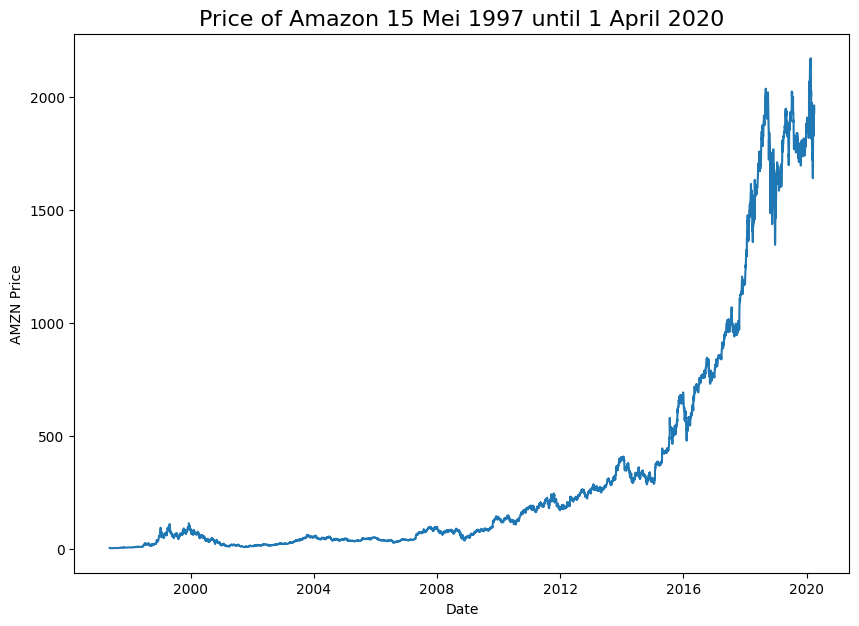

In [ ]:
# Plot from CSV

plt.figure(figsize=(10, 7))
plt.plot(timesteps, AMZN_price)
plt.title("Price of Amazon 15 Mei 1997 until 1 April 2020", fontsize=16)
plt.xlabel("Date")
plt.ylabel("AMZN Price");

Terdapat plot chart saham Amazon dari 15 mei 1997 sampai dengan 1 April 2020. char yang didapat terus mengalami penaikan sampai 2020.

[2.50000000e+00 1.97916663e+00 1.77083337e+00 ... 1.97363000e+03
 1.99302002e+03 1.94495996e+03]


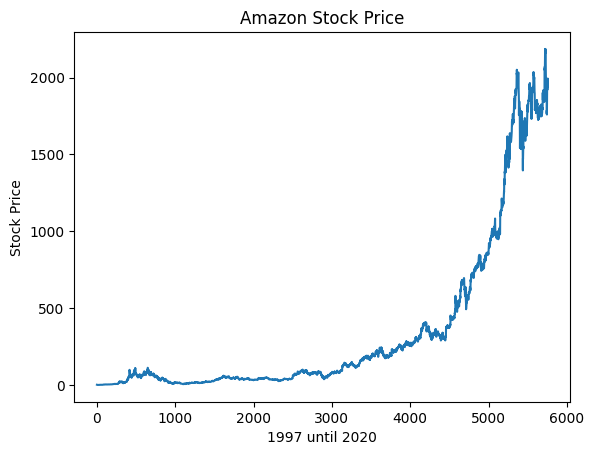

In [ ]:
data = dfAMZN.iloc[:,1].values
print(data)
plt.plot(data)
plt.xlabel("1997 until 2020")
plt.ylabel("Stock Price")
plt.title("Amazon Stock Price")
plt.show()

## Explore dataset CSCO

In [ ]:
dfCSCO.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600


Menampilkan 5 data pertama

In [ ]:
len(dfCSCO)

7589

Terdapat 7589 length pada data Cisco.

In [ ]:
dfCSCO.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
print("Jumlah Baris Dataset CSCO:", len(dfCSCO))
print("Jumlah Kolom Dataset CSCO:", len(dfCSCO.columns))

Jumlah Baris Dataset CSCO: 7589
Jumlah Kolom Dataset CSCO: 6


In [ ]:
print(dfCSCO.isna().sum())
dfCSCO.shape

Setelah melakukan pengecekan missing value, TIdak terdapat missing value pada dataset AMZN, dapat dikatakan data bersih.

In [ ]:
print(dfCSCO.shape)
print(dfCSCO[dfCSCO.duplicated()].shape)

(7589, 6)
(0, 6)


Tidak ada data yang terduplikat itu artinya setiap baris dalam dataset memiliki nilai yang unik.

In [ ]:
# Buat variabel baru yang berisi
pricesCisco = pd.DataFrame(dfCSCO["Close"]).rename(columns={"Close": "Price"})
pricesCisco.head()

,Price
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559


Variabel diatas dibuat untuk harga penutupan saham pada periode tertentu. Saya memilih Close untuk variabel baru berdasarkan pada paper Yadav et.al., harga penutupan merupakkan harga standar yang dipertimbangkan selama analisis pada deret waktu keuangan. Harga close juga sudah disesuaikan dengan pemecahan, hal ini mempengaruhi "nominal" harga saham [1].


[1]  Yadav, A., Jha, C. K., & Sharan, A. (2020). Optimizing LSTM for time series prediction in Indian stock market. Procedia Computer Science, 167, 2091-2100.


In [ ]:
timesteps = []
CSCO_price = []
with open("CSCO.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")  # read in the target CSV
    next(csv_reader)  # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[0], "%Y-%m-%d"))  # get the dates as dates (not strings)
        CSCO_price.append(float(line[1]))  # get the closing price as float

# View first 10 of each
timesteps[:10], CSCO_price[:10]

([datetime.datetime(1990, 2, 16, 0, 0),
  datetime.datetime(1990, 2, 20, 0, 0),
  datetime.datetime(1990, 2, 21, 0, 0),
  datetime.datetime(1990, 2, 22, 0, 0),
  datetime.datetime(1990, 2, 23, 0, 0),
  datetime.datetime(1990, 2, 26, 0, 0),
  datetime.datetime(1990, 2, 27, 0, 0),
  datetime.datetime(1990, 2, 28, 0, 0),
  datetime.datetime(1990, 3, 1, 0, 0),
  datetime.datetime(1990, 3, 2, 0, 0)],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Menjadikan data tersebut dengan format date time pada colomn Date.

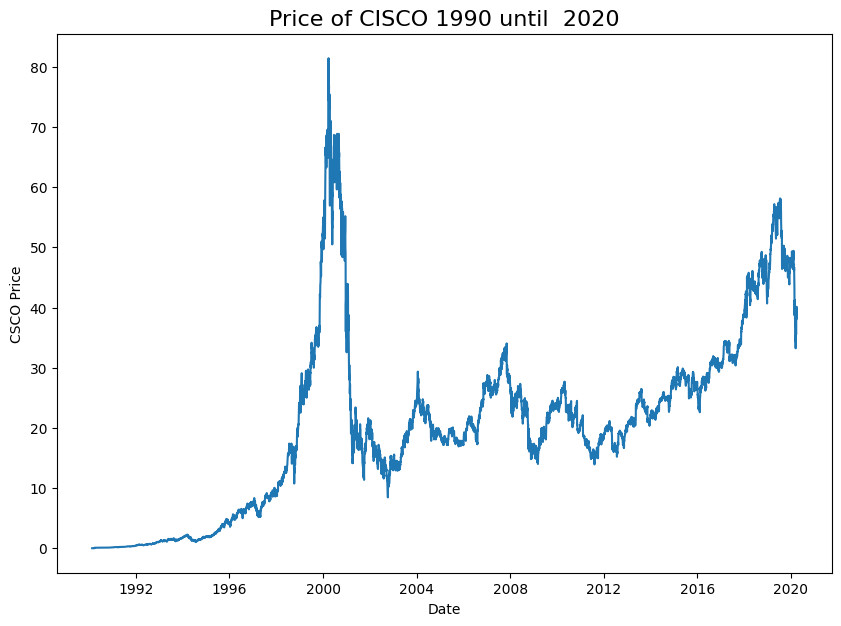

In [ ]:
# Plot from CSV

plt.figure(figsize=(10, 7))
plt.plot(timesteps, CSCO_price)
plt.title("Price of CISCO 1990 until  2020", fontsize=16)
plt.xlabel("Date")
plt.ylabel("CSCO Price");

Plot diatas menunjukkan pergerakan harga saham dari tahun 1990 sampai dengan 1 April 2020, harga tersebut berdasarkan harga penutupan saham perharinya dari hari senin hingga jumat. Kita dapat melihat pada grafik diatas harga cenderung bergerak keatas atau uptrend. puncaknya ada pada tahun 2000 an setelah itu harga mulai bergerak menurun dengan tajam hingga tahun 2003 mengalami kenaikan namun tidak significant karena bergerak tak menentu. pada tahun 2012 sudah dikatakan trend bullish hingga awal 2020 kembali mengalami penurunan.

[ 0.07986111  0.07986111  0.07899305 ... 40.49000168 40.41999817
 38.86000061]


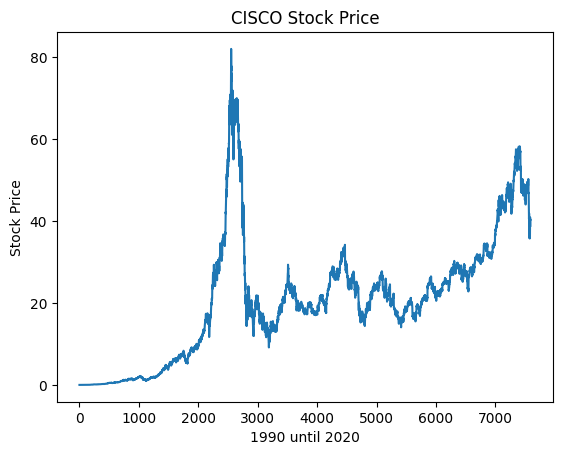

In [ ]:
data = dfCSCO.iloc[:,1].values
print(data)
plt.plot(data)
plt.xlabel("1990 until 2020")
plt.ylabel("Stock Price")
plt.title("CISCO Stock Price")
plt.show()

Ini merupakan stock price dari saham Cisco dari tahun 1990 sampai dengan tahun 2020.

## Preprocessing Data AMZN

In [ ]:
timesteps = pricesAmazon.index.to_numpy()
prices = pricesAmazon["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['1997-05-15T00:00:00.000000000', '1997-05-16T00:00:00.000000000',
        '1997-05-19T00:00:00.000000000', '1997-05-20T00:00:00.000000000',
        '1997-05-21T00:00:00.000000000', '1997-05-22T00:00:00.000000000',
        '1997-05-23T00:00:00.000000000', '1997-05-27T00:00:00.000000000',
        '1997-05-28T00:00:00.000000000', '1997-05-29T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([1.95833337, 1.72916663, 1.70833337, 1.63541663, 1.42708337,
        1.39583337, 1.5       , 1.58333337, 1.53125   , 1.50520837]))

code diatas untuk mempersiapkan timestamps dan price dalam format yang sesuai untuk proses selanjutnya. Code diatas untuk mengambil timesteps dan harga saham dari dataframe pricesAmazon kemudian mengubahnya dalam numpy array.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Reshape data
data = dfAMZN['Close'].values.reshape(-1, 1)

# Scaling using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define constants
HORIZON = 1
WINDOW_SIZE = 5

def get_labelled_windows(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=5, horizon=1):
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

# Create windows and labels
full_windows, full_labels = make_windows(scaled_data, window_size=WINDOW_SIZE, horizon=HORIZON)

print("Length of full windows:", len(full_windows))
print("Length of full labels:", len(full_labels))


Length of full windows: 5753
Length of full labels: 5753


- pada code diatas terdapat tahapan-tahapan preprocessing data seperti Reshaping Data, Scaling Data, Pembuatan Windows dan Labels.
Reshape pada colomn price berfungsi untuk mengubah menjadi numpy array dan memastikan bahwa untuk proses selanjutnya dapat berjalan.

- Scaling. Pada proses scaling saya menggunakan MinMaxScaler karena dalam paper Deepa et.al., MinMaxScaler dapat mengubah data kedalam rentang yang telah ditentukan. contohnya 0 sampai 1. dengan memakai MinMaxScaler rentang data yang sama dapat memperbaiki stabilitas algoritma machine learning. selain itu dengan MinMaxScaler data yang memiliki tingkat range yang jauh akan menghasilkan nilai yang tidak akurat, jadi dengan menggunakan MinMaxScaler akan mengubah skala menjadi rentang yang sama sehingga model yang dihasilkan akan lebih konsisten [2].


- Kemudian alasan saya memilih untuk mengscaling data adalah karena menurut paper Yadav et.al, data input di scaling agar sesuai dengan rentang fungsi aktivasi. Scaling juga umum digunakan dalam membuat arsitektur jaringan saraf, alasan utama saya adalah dengan melakukan scaling akan mendapatkan hasil yang akurat [1].

[1]  Yadav, A., Jha, C. K., & Sharan, A. (2020). Optimizing LSTM for time series prediction in Indian stock market. Procedia Computer Science, 167, 2091-2100.  
[2]  Deepa, B., & Ramesh, K. (2022). Epileptic seizure detection using deep learning through min max scaler normalization. Int. J. Health Sci, 6, 10981-10996.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 5

def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(6)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")


def make_windows(x, window_size=5, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window: [1 2 3 4 5] -> Label: 6


(5753, 5753)

Function get_labelled_windows dibuat untuk membagi data X menjadi 2 buah bagian.  deret waktu menjadi window dan label yang sesuai untuk melatih model prediksi deret waktu dengan memanfaatkan data yang telah ada.

Function make_windows digunakan untuk membagi deret waktu tersebut menjadikannya label dan window yang sesuai dengan ukuran window (dari hari senin hingga jumat) dan horizon (hanya hari senin) yang telah ditentukan didalam soal.

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [[2.59357128e-04]
 [1.53693076e-04]
 [1.44087293e-04]
 [1.10466888e-04]
 [1.44087293e-05]] -> Label: [[0.]]
Window: [[1.53693076e-04]
 [1.44087293e-04]
 [1.10466888e-04]
 [1.44087293e-05]
 [0.00000000e+00]] -> Label: [[4.80290795e-05]]
Window: [[1.44087293e-04]
 [1.10466888e-04]
 [1.44087293e-05]
 [0.00000000e+00]
 [4.80290795e-05]] -> Label: [[8.64523761e-05]]


Output diatas menampilkan 3 windows pertama, dengan adanya output ini kita bisa melihat nilai yang terkandung di dalam window dan label.
Output dari code diatas berarti window pertama merupakan array 2 dimensi dengan nilai [[2.59357128e-04]
 [1.53693076e-04]
 [1.44087293e-04]
 [1.10466888e-04]
 [1.44087293e-05]]
 dan label nya yaitu [0.] begitupun seterusnya.


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [[0.87671199]
 [0.89389642]
 [0.86887826]
 [0.90099244]
 [0.87545325]] -> Label: [[0.90489316]]
Window: [[0.89389642]
 [0.86887826]
 [0.90099244]
 [0.87545325]
 [0.90489316]] -> Label: [[0.89833201]]
Window: [[0.86887826]
 [0.90099244]
 [0.87545325]
 [0.90489316]
 [0.89833201]] -> Label: [[0.87895744]]


Output diatas menampilkan 3 windows terakhir, dengan adanya output ini kita bisa melihat nilai yang terkandung di dalam window dan label.
Output dari code diatas berarti window pertama merupakan array 2 dimensi dengan nilai [[0.87671199]
 [0.89389642]
 [0.86887826]
 [0.90099244]
 [0.87545325]] dan Label: [[0.90489316]]
 begitupun seterusnya.

## Preprocessing Data CSCO

In [ ]:
timesteps_cisco = pricesCisco.index.to_numpy()
prices_cisco = pricesCisco["Price"].to_numpy()

timesteps_cisco[:10], prices_cisco[:10]

(array(['1990-02-16T00:00:00.000000000', '1990-02-20T00:00:00.000000000',
        '1990-02-21T00:00:00.000000000', '1990-02-22T00:00:00.000000000',
        '1990-02-23T00:00:00.000000000', '1990-02-26T00:00:00.000000000',
        '1990-02-27T00:00:00.000000000', '1990-02-28T00:00:00.000000000',
        '1990-03-01T00:00:00.000000000', '1990-03-02T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([0.07725695, 0.07986111, 0.078125  , 0.07899305, 0.07855903,
        0.07638889, 0.078125  , 0.08072916, 0.07986111, 0.08072916]))

code diatas untuk mempersiapkan timestamps dan price dalam format yang sesuai untuk proses selanjutnya. Code diatas untuk mengambil timesteps dan harga saham dari dataframe pricesAmazon kemudian mengubahnya dalam numpy array.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Reshape data
data = dfCSCO['Close'].values.reshape(-1, 1)

# Scaling using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define constants
HORIZON = 1
WINDOW_SIZE = 5

def get_labelled_windows(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=5, horizon=1):
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
    windowed_array = x[window_indexes]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

# Create windows and labels
full_windows, full_labels = make_windows(scaled_data, window_size=WINDOW_SIZE, horizon=HORIZON)

print("Length of full windows:", len(full_windows))
print("Length of full labels:", len(full_labels))


Length of full windows: 7584
Length of full labels: 7584


- pada code diatas terdapat tahapan-tahapan preprocessing data seperti Reshaping Data, Scaling Data, Pembuatan Windows dan Labels.
Reshape pada colomn price berfungsi untuk mengubah menjadi numpy array dan memastikan bahwa untuk proses selanjutnya dapat berjalan.

- Scaling. Pada proses scaling saya menggunakan MinMaxScaler karena dalam paper Deepa et.al., MinMaxScaler dapat mengubah data kedalam rentang yang telah ditentukan. contohnya 0 sampai 1. dengan memakai MinMaxScaler rentang data yang sama dapat memperbaiki stabilitas algoritma machine learning. selain itu dengan MinMaxScaler data yang memiliki tingkat range yang jauh akan menghasilkan nilai yang tidak akurat, jadi dengan menggunakan MinMaxScaler akan mengubah skala menjadi rentang yang sama sehingga model yang dihasilkan akan lebih konsisten [2].


- Kemudian alasan saya memilih untuk mengscaling data adalah karena menurut paper Yadav et.al, data input di scaling agar sesuai dengan rentang fungsi aktivasi. Scaling juga umum digunakan dalam membuat arsitektur jaringan saraf, alasan utama saya adalah dengan melakukan scaling akan mendapatkan hasil yang akurat [1].

[1]  Yadav, A., Jha, C. K., & Sharan, A. (2020). Optimizing LSTM for time series prediction in Indian stock market. Procedia Computer Science, 167, 2091-2100.  
[2]  Deepa, B., & Ramesh, K. (2022). Epileptic seizure detection using deep learning through min max scaler normalization. Int. J. Health Sci, 6, 10981-10996.

In [ ]:
HORIZON = 1
WINDOW_SIZE = 5

def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(6)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")


def make_windows(x, window_size=5, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

full_windows, full_labels = make_windows(prices_cisco, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

Window: [1 2 3 4 5] -> Label: 6


(7584, 7584)

Function get_labelled_windows dibuat untuk membagi data X menjadi 2 buah bagian.  deret waktu menjadi window dan label yang sesuai untuk melatih model prediksi deret waktu dengan memanfaatkan data yang telah ada.

Function make_windows digunakan untuk membagi deret waktu tersebut menjadikannya label dan window yang sesuai dengan ukuran window (dari hari senin hingga jumat) dan horizon (hanya hari senin) yang telah ditentukan didalam soal.

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [0.07725695 0.07986111 0.078125   0.07899305 0.07855903] -> Label: [0.07638889]
Window: [0.07986111 0.078125   0.07899305 0.07855903 0.07638889] -> Label: [0.078125]
Window: [0.078125   0.07899305 0.07855903 0.07638889 0.078125  ] -> Label: [0.08072916]


Output diatas menampilkan 3 windows pertama, dengan adanya output ini kita bisa melihat nilai yang terkandung di dalam window dan label.
Output dari code diatas berarti window pertama merupakan array 2 dimensi dengan nilai [0.07725695 0.07986111 0.078125   0.07899305 0.07855903] -> Label: [0.07638889] begitupun seterusnya.


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [34.59999847 38.59999847 37.66999817 40.58000183 38.81999969] -> Label: [40.31999969]
Window: [38.59999847 37.66999817 40.58000183 38.81999969 40.31999969] -> Label: [39.31000137]
Window: [37.66999817 40.58000183 38.81999969 40.31999969 39.31000137] -> Label: [38.33000183]


Output diatas menampilkan 3 windows terakhir, dengan adanya output ini kita bisa melihat nilai yang terkandung di dalam window dan label.
Output dari code diatas berarti window pertama merupakan array 2 dimensi dengan nilai [34.59999847 38.59999847 37.66999817 40.58000183 38.81999969] -> Label: [40.31999969]
 begitupun seterusnya.

## Split (80 train, 10 val, 10 test) Dataset Amazon


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2, val_split=0.1):
  """
  Splits matching pairs of windows and labels into train, test, and validation splits.
  """
  # Calculate the sizes of train, test, and validation sets
  num_samples = len(windows)
  train_size = int(num_samples * (1 - test_split - val_split))
  test_size = int(num_samples * test_split)
  val_size = int(num_samples * val_split)

  # Split the data into train, test, and validation sets
  train_windows = windows[:train_size]
  train_labels = labels[:train_size]
  test_windows = windows[train_size:train_size + test_size]
  test_labels = labels[train_size:train_size + test_size]
  val_windows = windows[train_size + test_size:]
  val_labels = labels[train_size + test_size:]

  return train_windows, test_windows, val_windows, train_labels, test_labels, val_labels


Function make_train_test_splits digunakan untuk membagi data dengan proporsi 80% train data, 10% validation data, dan 10% testing.
Windows dan labels data dibagi berdasarkan proporsinya.
Menghasilkan 6 variabel: train_windows, test_windows, val_windows, train_labels,
test_labels, dan val_labels. Masing-masing berisi window data dan label untuk set training, validation, dan testing.


In [ ]:
train_windows, test_windows, val_windows, train_labels, test_labels, val_labels = make_train_test_splits(full_windows, full_labels, test_split=0.1, val_split=0.1)
len(train_windows), len(test_windows), len(val_windows), len(train_labels), len(test_labels), len(val_labels)


(4602, 575, 576, 4602, 575, 576)

Didapatkan hasil dari pembagian yang sudah dilakukan sebelumnya pada proses spliting data. training data sebesar 4602, validasi sebesar 575 data, dan testing sebesar 576 data.

In [ ]:
train_windows, test_windows, val_windows, train_labels, test_labels, val_labels = make_train_test_splits(full_windows, full_labels, test_split=0.1, val_split=0.1)

# Melihat lima sampel pertama dari train_windows
print("Train Windows:")
for i in range(5):
    print(train_windows[i])

# Melihat lima sampel pertama dari train_labels
print("\nTrain Labels:")
for i in range(5):
    print(train_labels[i])


Train Windows:
[0.07725695 0.07986111 0.078125   0.07899305 0.07855903]
[0.07986111 0.078125   0.07899305 0.07855903 0.07638889]
[0.078125   0.07899305 0.07855903 0.07638889 0.078125  ]
[0.07899305 0.07855903 0.07638889 0.078125   0.08072916]
[0.07855903 0.07638889 0.078125   0.08072916 0.07986111]

Train Labels:
[0.07638889]
[0.078125]
[0.08072916]
[0.07986111]
[0.08072916]


Output tersebut untuk melihat 5 sample pertama dari train_windows dan dari train_labels dari nilai training set setelah split data.

In [ ]:
# Reshape test_windows
test_windows_reshaped = np.reshape(test_windows, (test_windows.shape[0], test_windows.shape[1]))


melakukan reshape data berfungsi untuk mempersiapkan data sebelum modeling.

## Split (80 train, 10 val, 10 test) Dataset Cisco


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2, val_split=0.1):
  """
  Splits matching pairs of windows and labels into train, test, and validation splits.
  """
  # Calculate the sizes of train, test, and validation sets
  num_samples = len(windows)
  train_size = int(num_samples * (1 - test_split - val_split))
  test_size = int(num_samples * test_split)
  val_size = int(num_samples * val_split)

  # Split the data into train, test, and validation sets
  train_windows = windows[:train_size]
  train_labels = labels[:train_size]
  test_windows = windows[train_size:train_size + test_size]
  test_labels = labels[train_size:train_size + test_size]
  val_windows = windows[train_size + test_size:]
  val_labels = labels[train_size + test_size:]

  return train_windows, test_windows, val_windows, train_labels, test_labels, val_labels


Function make_train_test_splits digunakan untuk membagi data dengan proporsi 80% train data, 10% validation data, dan 10% testing.
Windows dan labels data dibagi berdasarkan proporsinya.
Menghasilkan 6 variabel: train_windows, test_windows, val_windows, train_labels,
test_labels, dan val_labels. Masing-masing berisi window data dan label untuk set training, validation, dan testing.


In [ ]:
train_windows2, test_windows2, val_windows2, train_labels2, test_labels2, val_labels2 = make_train_test_splits(full_windows, full_labels, test_split=0.1, val_split=0.1)
len(train_windows2), len(test_windows2), len(val_windows2), len(train_labels2), len(test_labels2), len(val_labels2)


(6067, 758, 759, 6067, 758, 759)

Didapatkan hasil dari pembagian yang sudah dilakukan sebelumnya pada proses spliting data. training data sebesar 4602, validasi sebesar 575 data, dan testing sebesar 576 data.

In [ ]:
train_windows2, test_windows2, val_windows2, train_labels2, test_labels2, val_labels2 = make_train_test_splits(full_windows, full_labels, test_split=0.1, val_split=0.1)

# Melihat lima sampel pertama dari train_windows
print("Train Windows:")
for i in range(5):
    print(train_windows2[i])

# Melihat lima sampel pertama dari train_labels
print("\nTrain Labels:")
for i in range(5):
    print(train_labels2[i])

Train Windows:
[0.07725695 0.07986111 0.078125   0.07899305 0.07855903]
[0.07986111 0.078125   0.07899305 0.07855903 0.07638889]
[0.078125   0.07899305 0.07855903 0.07638889 0.078125  ]
[0.07899305 0.07855903 0.07638889 0.078125   0.08072916]
[0.07855903 0.07638889 0.078125   0.08072916 0.07986111]

Train Labels:
[0.07638889]
[0.078125]
[0.08072916]
[0.07986111]
[0.08072916]


Output tersebut untuk melihat 5 sample pertama dari train_windows dan dari train_labels dari nilai training set setelah split data.

In [ ]:
# Reshape test_windows
test_windows_reshaped = np.reshape(test_windows2, (test_windows2.shape[0], test_windows2.shape[1]))


melakukan reshape data berfungsi untuk mempersiapkan data sebelum modeling.

#### b. [LO 3, LO 4, 5 poin] Buatlah arsitektur baseline dengan LSTM (units=50) dan layer akhir berupanode Perceptron dengan units=1. Activation function untuk LSTM menggunakan ReLU


## LSTM sebagai BASELINE Dataset AMZN

Membuat function untuk nilai dari mae, rmse, mape

In [ ]:
def baselineModel():
    model1 = Sequential()
    model1.add(LSTM(units=50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model1.add(Dense(units=1))
    return model1

baseline_model = baselineModel()
baseline_model.compile(loss='mse', optimizer='adam')
baseline_model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_75 (LSTM)              (None, 50)                10400     
                                                                 
 dense_60 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Function baselineModel digunakan untuk menghasilkan model baseline yang digunakan untuk memprediksi dari pergerakan harga saham. Dengan menggunakan LSTM sebesar 50 units dan layer akhir berupa node perceptron dengan units 1, Activation function untuk LSTM menggunakan ReLU.

Output diatas menunjukkan bahwa jumlah parameter pada layer tersebut adalah 10.451.
Arsitektur model :
- Model tersebut menggunakan LSTM 50 units, activation function relu, dan layer akhir berupa
node Perceptron dengan units=1.
- Model tersebut mengkompilasi model baseline yang telah dibuat sebelumnya. Dengan menggunakan 'loss=mse' parameter ini mengatur fungsi loss dalam training. Mean Square Error atau biasa disingkat MSE merupakan metrik umum yang digunakan untuk mengukur nilai prediksi dan nilai aktual.
- optimizer='adam' untuk memperbarui parameter model selama training [5].

Referensi :
[5]  Buchwalder, M., Bühlmann, H., Merz, M., & Wüthrich, M. V. (2006). The mean square error of prediction in the chain ladder reserving method (Mack and Murphy revisited). ASTIN Bulletin: The Journal of the IAA, 36(2), 521-542.





In [ ]:
# Train the model
train = baseline_model.fit(train_windows, train_labels,
                             validation_data=(val_windows, val_labels),
                             epochs=15, batch_size=64)

# Evaluate the model on the test set
test_loss = baseline_model.evaluate(test_windows, test_labels)
print("Test Loss:", test_loss)

Epoch 1/15
72/72 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 0.0722
Epoch 2/15
72/72 [==============================] - 0s 4ms/step - loss: 2.6219e-05 - val_loss: 0.0044
Epoch 3/15
72/72 [==============================] - 0s 4ms/step - loss: 6.2924e-06 - val_loss: 0.0036
Epoch 4/15
72/72 [==============================] - 0s 4ms/step - loss: 6.2880e-06 - val_loss: 0.0032
Epoch 5/15
72/72 [==============================] - 0s 3ms/step - loss: 6.1843e-06 - val_loss: 0.0029
Epoch 6/15
72/72 [==============================] - 0s 3ms/step - loss: 5.9012e-06 - val_loss: 0.0024
Epoch 7/15
72/72 [==============================] - 0s 4ms/step - loss: 6.0087e-06 - val_loss: 0.0025
Epoch 8/15
72/72 [==============================] - 0s 4ms/step - loss: 6.3899e-06 - val_loss: 0.0022
Epoch 9/15
72/72 [==============================] - 0s 4ms/step - loss: 6.5003e-06 - val_loss: 0.0021
Epoch 10/15
72/72 [==============================] - 0s 4ms/step - loss: 5.9215e-06 - 

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 64.
- Test loss yang didapat sebesar 0,00% yang artinya sudah sangat bagus. Model yang dilatih sudah mendapatkan performa yang bagus terbukti dari hasil loss yang sangat kecil.


18/18 [==============================] - 0s 4ms/step


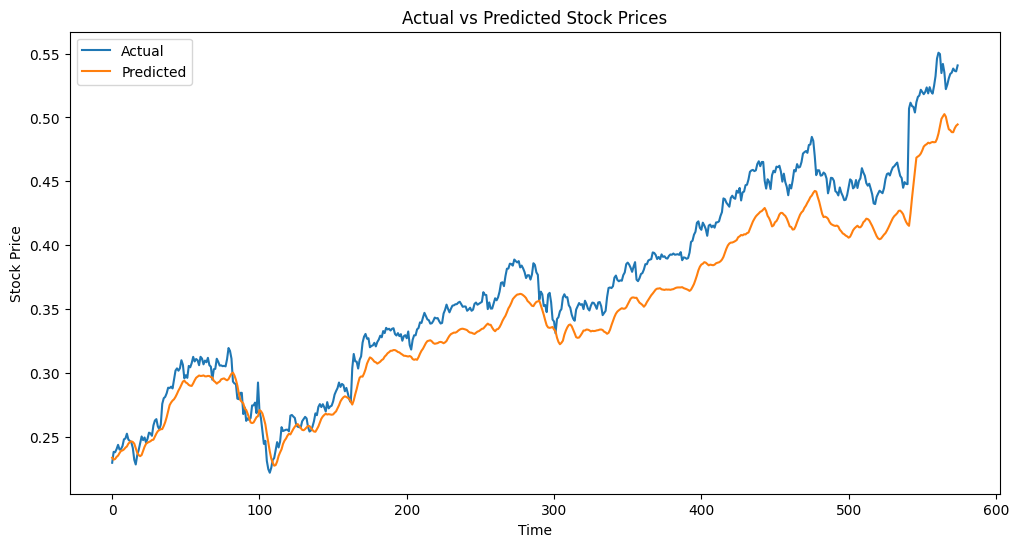

Baseline Model:
RMSE: 0.026350532062919662
MAE: 0.022857587625219077
MAPE:  0.05860113397286456


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get predictions from the baseline model
baseline_predictions = baseline_model.predict(test_windows)

# Flatten the predictions and test labels to 1D arrays
baseline_predictions = baseline_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
baseline_rmse = np.sqrt(mean_squared_error(test_labels, baseline_predictions))
baseline_mae = mean_absolute_error(test_labels, baseline_predictions)
baseline_mape = mean_absolute_percentage_error(test_labels, baseline_predictions)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(baseline_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE: ", baseline_mape)


Didapat baseline model dari Arsitekur LSTM Amazon dengan unit = 50 dan layer akhir node perceptron dengan unit = 1, serta Activation function.

Dapat dilihat nilai RMSE, MAE, MAPE sudah cukup terbilang bagus. dan plot sudah terlihat normal, meski plot tidak terlalu menyatu.

Hasil baseline dari arsitektur LSTM mendapatkan hasil :        

- RMSE: 2,2%
- MAE: 2,2%
- MAPE:  05,8%

hasil yang didapat sudah memiliki hasil yang cukup rendah, itu artinya sudah baik. Jika nilai RMSE, MAE, dan MAPE semakin rendah itu artinya model sudah bagus.

##Plot (Tidak Scaling)

18/18 [==============================] - 0s 1ms/step


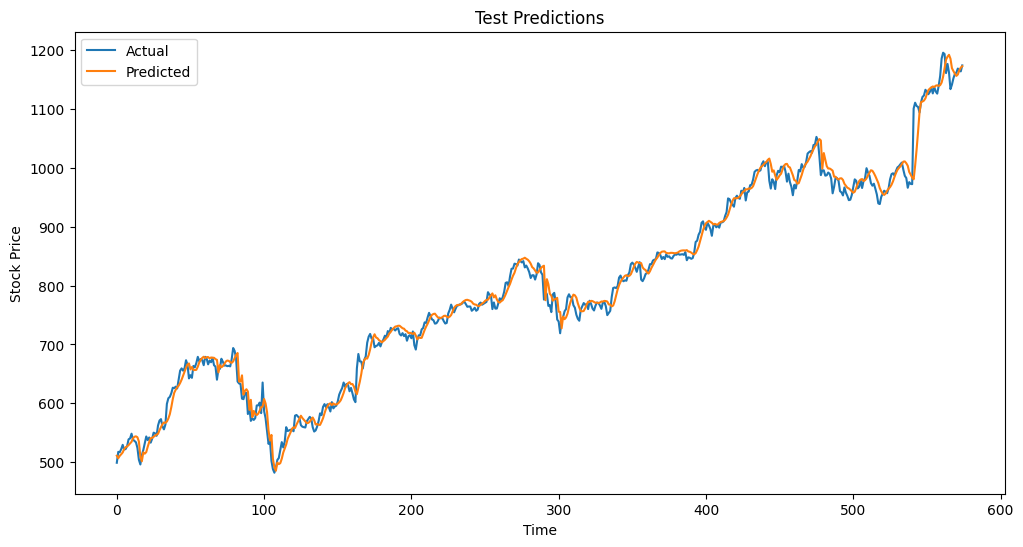

In [ ]:
import matplotlib.pyplot as plt

# Generate predictions
train_predictions = baseline_model.predict(train_windows)
val_predictions = baseline_model.predict(val_windows)
test_predictions = baseline_model.predict(test_windows)


# Plot test predictions
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('Test Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Ini merupakan Plot tanpa Scaling. Sesuai dengan argumen diatas yaitu mengscaling data adalah agar data input di scaling agar sesuai dengan rentang fungsi aktivasi. Scaling juga umum digunakan dalam membuat arsitektur jaringan saraf, alasan utama saya adalah dengan melakukan scaling akan mendapatkan hasil yang akurat [1].

dengan tidak menscaling data akan menghasilkan model yang kurang akurat, terbukti pada percobaan saya dengan ploting tidak menggunakan scaling.

[1] Yadav, A., Jha, C. K., & Sharan, A. (2020). Optimizing LSTM for time series prediction in Indian stock market. Procedia Computer Science, 167, 2091-2100.

## LSTM sebagai BASELINE Dataset CSCO

In [ ]:
def baselineModelCSCO():
    model1 = Sequential()
    model1.add(LSTM(units=50, activation='relu', input_shape=(WINDOW_SIZE, 1)))
    model1.add(Dense(units=1))
    return model1

baseline_model = baselineModelCSCO()
baseline_model.compile(loss='mse', optimizer='adam')
baseline_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Function baselineModel digunakan untuk menghasilkan model baseline yang digunakan untuk memprediksi dari pergerakan harga saham. Dengan menggunakan LSTM sebesar 50 units dan layer akhir berupa node perceptron dengan units 1, Activation function untuk LSTM menggunakan ReLU.

Output diatas menunjukkan bahwa jumlah parameter pada layer tersebut adalah 10.451.
Arsitektur model :
- Model tersebut menggunakan LSTM 50 units, activation function relu, dan layer akhir berupa
node Perceptron dengan units=1.
- Model tersebut mengkompilasi model baseline yang telah dibuat sebelumnya. Dengan menggunakan 'loss=mse' parameter ini mengatur fungsi loss dalam training. Mean Square Error atau biasa disingkat MSE merupakan metrik umum yang digunakan untuk mengukur nilai prediksi dan nilai aktual.
- optimizer='adam' untuk memperbarui parameter model selama training [5].

Referensi :
[5]  Buchwalder, M., Bühlmann, H., Merz, M., & Wüthrich, M. V. (2006). The mean square error of prediction in the chain ladder reserving method (Mack and Murphy revisited). ASTIN Bulletin: The Journal of the IAA, 36(2), 521-542.





In [ ]:
# Train the model
train = baseline_model.fit(train_windows2, train_labels2,
                             validation_data=(val_windows2, val_labels2),
                             epochs=15, batch_size=64)

# Evaluate the model on the test set
test_loss = baseline_model.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss)

Epoch 1/15
95/95 [==============================] - 2s 9ms/step - loss: 40.1075 - val_loss: 1.1449
Epoch 2/15
95/95 [==============================] - 1s 6ms/step - loss: 0.9439 - val_loss: 1.0028
Epoch 3/15
95/95 [==============================] - 1s 7ms/step - loss: 0.7227 - val_loss: 1.0530
Epoch 4/15
95/95 [==============================] - 1s 7ms/step - loss: 0.6496 - val_loss: 0.8248
Epoch 5/15
95/95 [==============================] - 1s 9ms/step - loss: 0.6209 - val_loss: 0.7208
Epoch 6/15
95/95 [==============================] - 1s 10ms/step - loss: 0.6156 - val_loss: 2.3965
Epoch 7/15
95/95 [==============================] - 1s 10ms/step - loss: 0.6073 - val_loss: 1.0153
Epoch 8/15
95/95 [==============================] - 1s 9ms/step - loss: 0.6048 - val_loss: 0.6622
Epoch 9/15
95/95 [==============================] - 1s 7ms/step - loss: 0.5664 - val_loss: 0.8673
Epoch 10/15
95/95 [==============================] - 1s 6ms/step - loss: 0.5590 - val_loss: 1.6540
Epoch 11/15
95/9

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 64.
- Test loss yang didapat sebesar 2,1%.


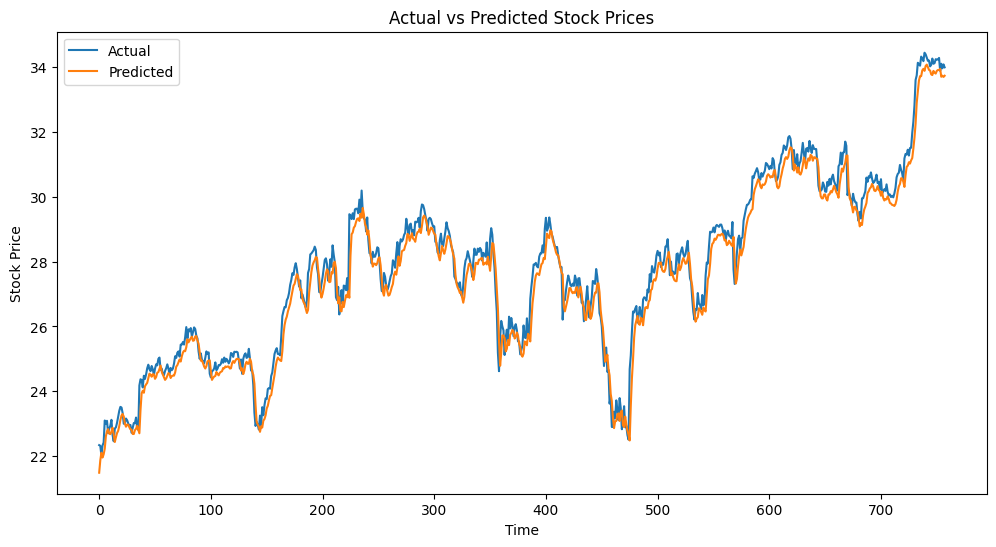

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels2, label='Actual')
plt.plot(baseline_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Dari plot diatas chart yang dihasilkan antara actual dan predicted sudah mirip dari yang aslinya, hal ini juga didukung dengan menggunakan minmaxscaler untuk mendapatkan hasil nilai prediksi yang lebih akurat. perbedaan antara actual dan predicted hanya tipis sekali dan dari bentuk semua sudah sama.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get predictions from the baseline model
baseline_predictions = baseline_model.predict(test_windows2)

# Flatten the predictions and test labels to 1D arrays
baseline_predictions = baseline_predictions.flatten()
test_labels = test_labels2.flatten()

# Calculate evaluation metrics
baseline_rmse = np.sqrt(mean_squared_error(test_labels2, baseline_predictions))
baseline_mae = mean_absolute_error(test_labels2, baseline_predictions)
baseline_mape = mean_absolute_percentage_error(test_labels2, baseline_predictions)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE: ", baseline_mape)

24/24 [==============================] - 0s 2ms/step
Baseline Model:
RMSE: 0.4671533895912917
MAE: 0.37193820470241257
MAPE:  0.013441341685941735


Didapat baseline model dari Arsitekur LSTM Cisco dengan unit = 50 dan layer akhir node perceptron dengan unit = 1, serta Activation function.

Dapat dilihat nilai RMSE, MAE, MAPE sudah cukup terbilang bagus. dan plot sudah terlihat normal, meski plot tidak terlalu menyatu.

Hasil baseline dari arsitektur LSTM mendapatkan hasil :        

- RMSE: 4,6%
- MAE: 3,7%
- MAPE:  0,1%

hasil yang didapat sudah memiliki hasil yang cukup rendah, itu artinya sudah baik. Jika nilai RMSE, MAE, dan MAPE semakin rendah itu artinya model sudah bagus.

#### C. [LO 1, LO 2, LO 3, LO 4, 15 poin] Setelah mengetahui hasil dari nomor (1c), modifikasi arsitektur pada nomor 1c untuk mendapatkan unjuk kerja yang optimal (kalian dapat menambahkan atau mengurangi arsitektur tersebut, atau mengganti hyperparameter, atau menggunakan tuning pada hyperparameter). Jelaskan alasan kalian untuk menggunakan pendekatan yang kalian pilih.

## Modifikasi 1

### Dataset AMZN

In [ ]:
#function untuk modifikasi arsitektur LSTM
def modif_model():
    model = Sequential()
    model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu'))

    #model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi1_model = modif_model()

# Compile the model
modifikasi1_model.compile(loss='mse', optimizer='adam')

# Print the model summary
modifikasi1_model.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_78 (LSTM)              (None, 5, 128)            66560     
                                                                 
 lstm_79 (LSTM)              (None, 64)                49408     
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


Pada modifikasi pertama saham Amazon, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU.

In [ ]:
# Train the model
history = modifikasi1_model.fit(train_windows, train_labels,
                             validation_data=(val_windows, val_labels),
                             epochs=25, batch_size=32)

# Evaluate the model on the test set
test_loss = modifikasi1_model.evaluate(test_windows, test_labels)
print("Test Loss:", test_loss)

Epoch 1/25
144/144 [==============================] - 4s 12ms/step - loss: 4.9691e-04 - val_loss: 0.0085
Epoch 2/25
144/144 [==============================] - 1s 10ms/step - loss: 9.7920e-06 - val_loss: 0.0041
Epoch 3/25
144/144 [==============================] - 2s 14ms/step - loss: 9.0531e-06 - val_loss: 0.0046
Epoch 4/25
144/144 [==============================] - 2s 11ms/step - loss: 1.0000e-05 - val_loss: 0.0049
Epoch 5/25
144/144 [==============================] - 1s 10ms/step - loss: 1.1225e-05 - val_loss: 0.0025
Epoch 6/25
144/144 [==============================] - 1s 10ms/step - loss: 1.0129e-05 - val_loss: 0.0039
Epoch 7/25
144/144 [==============================] - 1s 10ms/step - loss: 9.0692e-06 - val_loss: 0.0012
Epoch 8/25
144/144 [==============================] - 1s 10ms/step - loss: 9.5257e-06 - val_loss: 0.0020
Epoch 9/25
144/144 [==============================] - 1s 10ms/step - loss: 1.0755e-05 - val_loss: 0.0011
Epoch 10/25
144/144 [==============================] - 

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 64.
- Test loss yang didapat sebesar 0,00% yang artinya sudah sangat bagus. Model yang dilatih sudah mendapatkan performa yang bagus terbukti dari hasil loss yang sangat kecil.


In [ ]:
# Predict on the test set
modified_predictions = modifikasi1_model.predict(test_windows)

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels, modified_predictions))
modified_mae = mean_absolute_error(test_labels, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels, modified_predictions)

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)

18/18 [==============================] - 1s 7ms/step
Modified Model:
RMSE: 0.013452749992655116
MAE: 0.011297603250957158
MAPE: 0.03137449531045485


Dapat dilihat hasil dari Modifikasi model pertama mendapatkan hasil yang lebih baik dibanding baseline.
semakin kecil RSME, MAE, MAPE maka akan semakin bagus model modifikasi.

Saya menambahkan Layer LSTM kedalam arsitektur LSTM yang dibuat. kemudian saya menambahkan jumlah unit LSTM yang digunakan dalam layer sebanyak 64 units.  semakin besar jumlah unit akan semakin bagus juga kemampuan model dalam memproses dan melatih data yang ada [5].
Terakhir saya menambahkan parameter sebagai activation function untuk LSTM unit. ReLu digunakan sebagai fungsi aktivasi untuk lapisan tersembunyi dalam jaringan syaraf tiruan
jaringan saraf dalam [4].

[4]  Agarap, A. F. (2018). Deep learning using rectified linear units (relu). arXiv preprint arXiv:1803.08375.

[5]  Rao, A., & Spasojevic, N. (2016). Actionable and political text classification using word embeddings and LSTM. arXiv preprint arXiv:1607.02501.

18/18 [==============================] - 0s 10ms/step


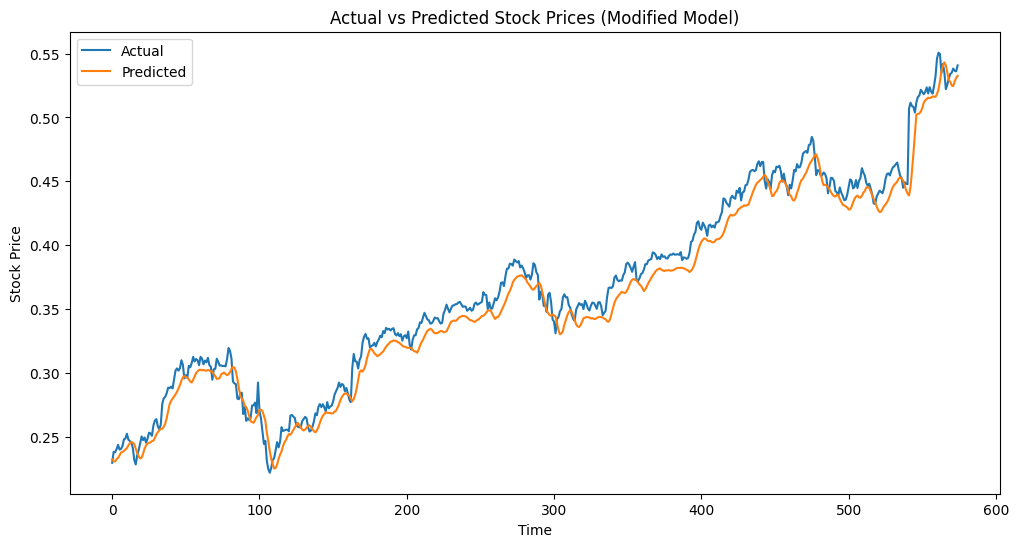

Modified Model:
RMSE: 0.013452749992655116
MAE: 0.011297603250957158
MAPE: 0.03137449531045485


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
modified_predictions = modifikasi1_model.predict(test_windows)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels, modified_predictions))
modified_mae = mean_absolute_error(test_labels, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels, modified_predictions)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Modified Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)


Pada modifikasi pertama didapatkan hasil sebagai berikut :     
- RMSE : 0.1%
- MAE : 0,1%
- MAPE : 0,3%

pada percobaan pertama didapatkan hasil yang lebih rendah daripada baseline, itu berarti bahwa model modifikasi pertama lebih bagus dan baik dibandingkan baseline, namun memang secara keseluruhan performa ataupun hasil yang didapat sama-sama memuaskan.

Dengan ditambahkannya pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU.


### Dataset CSCO

In [ ]:
#function untuk modifikasi arsitektur LSTM
def modif_model():
    model = Sequential()
    model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu'))

    #model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi1_model = modif_model()

# Compile the model
modifikasi1_model.compile(loss='mse', optimizer='adam')

# Print the model summary
modifikasi1_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 128)            66560     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


Pada modifikasi pertama saham Cisco, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU.

In [ ]:
# Train the model
history = modifikasi1_model.fit(train_windows2, train_labels2,
                             validation_data=(val_windows2, val_labels2),
                             epochs=10, batch_size=64)

# Evaluate the model on the test set
test_loss = modifikasi1_model.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss)

Epoch 1/10
95/95 [==============================] - 6s 26ms/step - loss: 47.4208 - val_loss: 3.6869
Epoch 2/10
95/95 [==============================] - 2s 21ms/step - loss: 1.2881 - val_loss: 1.8502
Epoch 3/10
95/95 [==============================] - 2s 22ms/step - loss: 1.3520 - val_loss: 1.8952
Epoch 4/10
95/95 [==============================] - 2s 23ms/step - loss: 1.0668 - val_loss: 3.4222
Epoch 5/10
95/95 [==============================] - 4s 37ms/step - loss: 0.9394 - val_loss: 1.0496
Epoch 6/10
95/95 [==============================] - 2s 22ms/step - loss: 0.7679 - val_loss: 3.1438
Epoch 7/10
95/95 [==============================] - 2s 21ms/step - loss: 0.7947 - val_loss: 3.6208
Epoch 8/10
95/95 [==============================] - 2s 23ms/step - loss: 0.6697 - val_loss: 0.7275
Epoch 9/10
95/95 [==============================] - 2s 23ms/step - loss: 0.6913 - val_loss: 3.5070
Epoch 10/10
24/24 [==============================] - 0s 8ms/step - loss: 0.8309
Test Loss: 0.830861985683441

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 64.
- Test loss yang didapat sebesar 0,00% yang artinya sudah sangat bagus. Model yang dilatih sudah mendapatkan performa yang bagus terbukti dari hasil loss yang sangat kecil.


In [ ]:
# Predict on the test set
modified_predictions = modifikasi1_model.predict(test_windows2)

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels2, modified_predictions))
modified_mae = mean_absolute_error(test_labels2, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels2, modified_predictions)

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)

24/24 [==============================] - 0s 6ms/step
Modified Model:
RMSE: 0.9115163217610056
MAE: 0.8307068580687832
MAPE: 0.029706065783108502


24/24 [==============================] - 0s 5ms/step


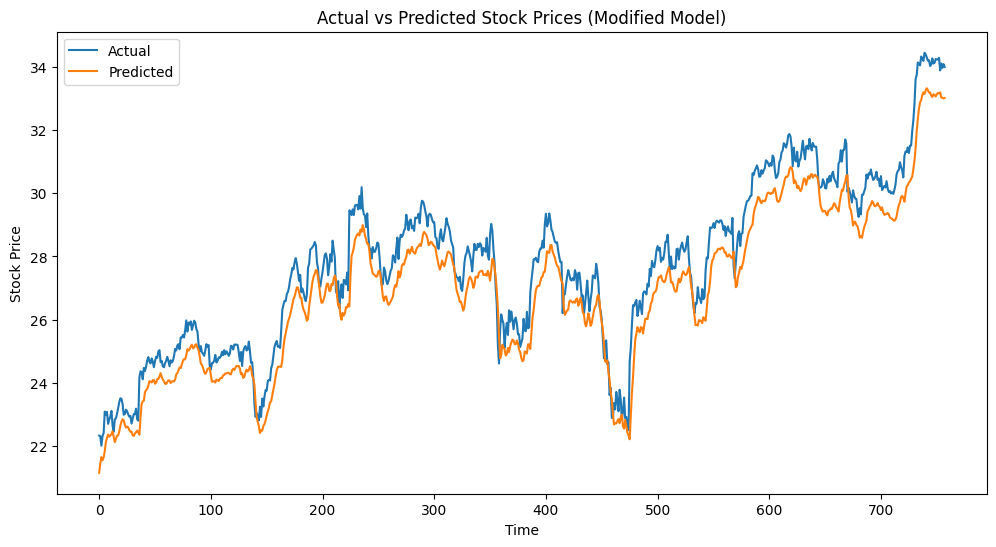

Modified Model:
RMSE: 0.9115163217610056
MAE: 0.8307068580687832
MAPE: 0.029706065783108502


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
modified_predictions = modifikasi1_model.predict(test_windows2)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels2, modified_predictions))
modified_mae = mean_absolute_error(test_labels2, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels2, modified_predictions)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Modified Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)


Pada modifikasi pertama dataset Cisco didapatkan hasil sebagai berikut :     
- RMSE : 9.1%
- MAE : 8,3%
- MAPE : 0,2%

pada percobaan pertama didapatkan hasil yang lebih tinggi daripada baseline, itu berarti bahwa model model baseline data Cisco lebih bagus dan baik dibandingkan modifikasi pertama, namun memang secara keseluruhan performa ataupun hasil yang didapat sama-sama memuaskan.

didapatkan perbedaan hasil walaupun menggunakan arsitektur modifikasi yang sama, masih belum diketahui pasti hal apa yang terjadi pada percobaan modifikasi pertama.

setelah membaca paper dan research lebih lanjut saya menemukan bahwa aat memulai pelatihan model, bobot model biasanya diinisialisasi secara acak. karena hal tersebut Inisialisasi awal yang berbeda dapat mengarah pada kondisi awal yang berbeda untuk model, yang pada gilirannya dapat mempengaruhi jalur optimasi yang diambil selama pelatihan. Hal ini dapat menyebabkan hasil yang berbeda antara percobaan yang berbeda.


Referensi :    
Bouthillier, X., Delaunay, P., Bronzi, M., Trofimov, A., Nichyporuk, B., Szeto, J., ... & Vincent, P. (2021). Accounting for variance in machine learning benchmarks. Proceedings of Machine Learning and Systems, 3, 747-769.



## Modifikasi 2

### Dataset amazon

In [ ]:
# Define the modified model
def modif_model():
    model = Sequential()
    model.add(LSTM(units=32, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(LSTM(units=128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(units=1))

    #model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi2_model = modif_model()

# Compile the model
modifikasi2_model.compile(loss='mse', optimizer='adam')

# Print the model summary
modifikasi2_model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_80 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_81 (LSTM)              (None, 5, 64)             24832     
                                                                 
 lstm_82 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_63 (Dense)            (None, 1)                 129       
                                                                 
 dense_64 (Dense)            (None, 1)                 2         
                                                                 
Total params: 128,131
Trainable params: 128,131
Non-t

Pada modifikasi ke-2 saham Amazon, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU Karena argumen return_sequences diatur sebagai default False.
- kemudian saya juga menambahkan Dropout layer untuk regularization.
- terdapat dense layer ditambahkan ke model. Dense merupakan layer biasa dnegan satu unit tanpa fungsi activasi.

In [ ]:
# Train the model
history = modifikasi2_model.fit(train_windows, train_labels,
                             validation_data=(val_windows, val_labels),
                             epochs=25, batch_size=32)

# Evaluate the model on the test set
test_loss = modifikasi2_model.evaluate(test_windows, test_labels)
print("Test Loss:", test_loss)

Epoch 1/25
144/144 [==============================] - 7s 16ms/step - loss: 8.1461e-04 - val_loss: 0.0369
Epoch 2/25
144/144 [==============================] - 2s 13ms/step - loss: 4.7014e-05 - val_loss: 0.0131
Epoch 3/25
144/144 [==============================] - 2s 12ms/step - loss: 4.6076e-05 - val_loss: 0.0120
Epoch 4/25
144/144 [==============================] - 2s 14ms/step - loss: 4.3488e-05 - val_loss: 0.0055
Epoch 5/25
144/144 [==============================] - 3s 18ms/step - loss: 4.0946e-05 - val_loss: 0.0057
Epoch 6/25
144/144 [==============================] - 2s 13ms/step - loss: 4.2370e-05 - val_loss: 0.0024
Epoch 7/25
144/144 [==============================] - 3s 18ms/step - loss: 4.4189e-05 - val_loss: 0.0032
Epoch 8/25
144/144 [==============================] - 3s 23ms/step - loss: 4.0934e-05 - val_loss: 0.0029
Epoch 9/25
144/144 [==============================] - 2s 14ms/step - loss: 3.5090e-05 - val_loss: 0.0010
Epoch 10/25
144/144 [==============================] - 

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 32.
- Test loss yang didapat sebesar 9,6% artinya model masih lebih bagus modifikasi pertama


18/18 [==============================] - 0s 6ms/step
Modified Model:
RMSE: 0.009835162782032522
MAE: 0.007036769384357762
MAPE: 0.02017197741943435


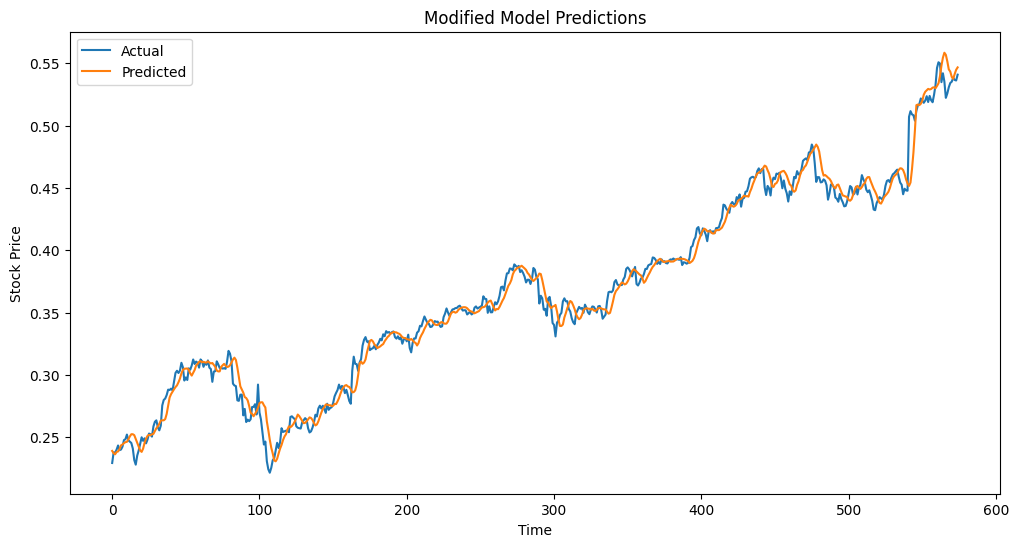

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test set
modified_predictions = modifikasi2_model.predict(test_windows)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels, modified_predictions))
modified_mae = mean_absolute_error(test_labels, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels, modified_predictions)

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Modified Model Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Hasil dari modifikasi ke-2 lebih rendah daripada sebelumnya yaitu sebesar
- RMSE 0.09%
- MAE 0.07%
- MAPE 0,2%

kemudian untuk plot sudah sangat bagus dan hampir menyerupai aslinya, memang secara garis sempit nilai prediksti dan nilai sebenarnya tidaklah dapat dikatakan identik. namun pada hasil RMSE, MAE, ataupun MAPE sudah dapat dikatakan bagus.

### Dataset Cisco

In [ ]:
def modif_model():
    model = Sequential()
    model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi2_model = modif_model()

# Compile the model
modifikasi2_model.compile(loss='mse', optimizer='adam')

# Print the model summary
modifikasi2_model.summary()
e-2

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 5, 128)            66560     
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


Pada modifikasi ke-2 saham Cisco, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU Karena argumen return_sequences diatur sebagai default False.
- kemudian saya juga menambahkan Dropout layer untuk regularization.
- terdapat dense layer ditambahkan ke model. Dense merupakan layer biasa dnegan satu unit tanpa fungsi activasi.

In [ ]:
# Train the model
history = modifikasi2_model.fit(train_windows2, train_labels2,
                             validation_data=(val_windows2, val_labels2),
                             epochs=10, batch_size=64)

# Evaluate the model on the test set
test_loss = modifikasi1_model.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss)

Epoch 1/10
95/95 [==============================] - 9s 42ms/step - loss: 33.8897 - val_loss: 2.6635
Epoch 2/10
95/95 [==============================] - 2s 24ms/step - loss: 1.2639 - val_loss: 1.3742
Epoch 3/10
95/95 [==============================] - 3s 29ms/step - loss: 1.0351 - val_loss: 1.0963
Epoch 4/10
95/95 [==============================] - 5s 51ms/step - loss: 0.7778 - val_loss: 1.2535
Epoch 5/10
95/95 [==============================] - 5s 53ms/step - loss: 0.9870 - val_loss: 1.0244
Epoch 6/10
95/95 [==============================] - 3s 30ms/step - loss: 0.7326 - val_loss: 1.6767
Epoch 7/10
95/95 [==============================] - 2s 23ms/step - loss: 0.8378 - val_loss: 1.4314
Epoch 8/10
95/95 [==============================] - 2s 22ms/step - loss: 0.7996 - val_loss: 1.7365
Epoch 9/10
95/95 [==============================] - 3s 33ms/step - loss: 0.6720 - val_loss: 0.8279
Epoch 10/10
24/24 [==============================] - 0s 6ms/step - loss: 0.8309
Test Loss: 0.830861985683441

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 32.
- Test loss yang didapat sebesar 8,3% artinya model masih lebih bagus modifikasi pertama.
- Loss sudah mengalami penurunan dari awal hingga epoch ke 15.



## Modifikasi 3

### Dataset Amazon

In [ ]:
# Define the modified model
def modif_model():
    model = Sequential()
    model.add(LSTM(units=32, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(LSTM(units=128, activation='relu'))
    #model.add(Dropout(0.2))  # Dropout layer for regularization
    model.add(Dense(units=64, activation='relu'))

    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi3_model = modif_model()

# Compile the model
modifikasi3_model.compile(loss='mse', optimizer='adam')

# Print the model summary
modifikasi3_model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_86 (LSTM)              (None, 5, 32)             4352      
                                                                 
 lstm_87 (LSTM)              (None, 5, 64)             24832     
                                                                 
 lstm_88 (LSTM)              (None, 128)               98816     
                                                                 
 dense_67 (Dense)            (None, 64)                8256      
                                                                 
 dense_68 (Dense)            (None, 1)                 65        
                                                                 
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


Pada modifikasi ke-3 saham Amazon, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU.
- menambahkan layer LSTM dengan 128 unit dengan menggunakan fungsi activation ReLU.
- saya juga menghapus dropout karena dalam beberapa kasus model dapat memberikan performa yang baik tanpa dropout. saya menghilangkan dropout jika agar mempercepat proses pelatihan karena tanpa dropout model sudah berjalan baik.

referensi
Nicoletti, M. D. C. (2019). Revisiting the Tinto's theoretical dropout model. Higher Education Studies, 9(3), 52-64.

In [ ]:
# Train the model
history = modifikasi3_model.fit(train_windows, train_labels,
                             validation_data=(val_windows, val_labels),
                             epochs=10, batch_size=64)

# Evaluate the model on the test set
test_loss = modifikasi3_model.evaluate(test_windows, test_labels)
print("Test Loss:", test_loss)

Epoch 1/10
72/72 [==============================] - 2s 29ms/step - loss: 1.0655e-05 - val_loss: 0.0136
Epoch 2/10
72/72 [==============================] - 1s 15ms/step - loss: 8.8726e-06 - val_loss: 0.0161
Epoch 3/10
72/72 [==============================] - 1s 15ms/step - loss: 9.4207e-06 - val_loss: 0.0126
Epoch 4/10
72/72 [==============================] - 1s 15ms/step - loss: 8.3852e-06 - val_loss: 0.0112
Epoch 5/10
72/72 [==============================] - 1s 15ms/step - loss: 9.7076e-06 - val_loss: 0.0092
Epoch 6/10
72/72 [==============================] - 1s 15ms/step - loss: 8.9977e-06 - val_loss: 0.0120
Epoch 7/10
72/72 [==============================] - 1s 16ms/step - loss: 9.8387e-06 - val_loss: 0.0161
Epoch 8/10
72/72 [==============================] - 1s 15ms/step - loss: 8.6487e-06 - val_loss: 0.0113
Epoch 9/10
72/72 [==============================] - 1s 16ms/step - loss: 8.6368e-06 - val_loss: 0.0150
Epoch 10/10
18/18 [==============================] - 0s 4ms/step - loss: 

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 64.
- Test loss yang didapat sebesar 0,00% yang artinya sudah sangat bagus. Model yang dilatih sudah mendapatkan performa yang bagus terbukti dari hasil loss yang sangat kecil.


In [ ]:
# Predict on the test set
modified_predictions = modifikasi3_model.predict(test_windows)

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels, modified_predictions))
modified_mae = mean_absolute_error(test_labels, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels, modified_predictions)

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)

18/18 [==============================] - 0s 4ms/step
Modified Model:
RMSE: 0.010316041629209323
MAE: 0.007773785315452077
MAPE: 0.02215173732744555


18/18 [==============================] - 0s 4ms/step
Modified Model:
RMSE: 0.010316041629209323
MAE: 0.007773785315452077
MAPE: 0.02215173732744555


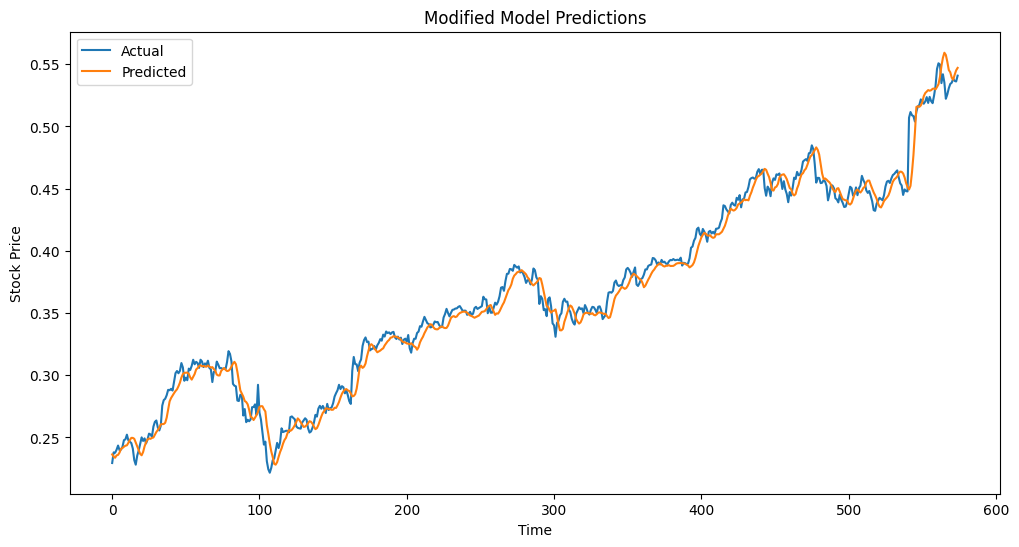

In [ ]:
import matplotlib.pyplot as plt

# Predict on the test set
modified_predictions = modifikasi3_model.predict(test_windows)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels, modified_predictions))
modified_mae = mean_absolute_error(test_labels, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels, modified_predictions)

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Modified Model Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Hasil dari modifikasi ke-3 lebih besar daripada sebelumnya yaitu sebesar
- RMSE 0.01%
- MAE 0.07%
- MAPE 0,2%

kemudian untuk plot sudah sangat bagus dan hampir menyerupai aslinya, memang secara garis sempit nilai prediksti dan nilai sebenarnya tidaklah dapat dikatakan identik. namun pada hasil RMSE, MAE, ataupun MAPE sudah dapat dikatakan bagus.

### Dataset Cisco

In [ ]:
def modif_model():
    model = Sequential()
    model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(LSTM(units=32, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi3_model = modif_model()

# Compile the model
modifikasi3_model.compile(loss='mse', optimizer='adam')

# Print the model summary
modifikasi3_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 5, 128)            66560     
                                                                 
 lstm_20 (LSTM)              (None, 5, 64)             49408     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 130,561
Trainable params: 130,561
Non-trainable params: 0
_________________________________________________________________


Pada modifikasi ke-3 saham Cisco, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU.
- menambahkan layer LSTM dengan 128 unit dengan menggunakan fungsi activation ReLU.
- saya juga menghapus dropout karena dalam beberapa kasus model dapat memberikan performa yang baik tanpa dropout. saya menghilangkan dropout jika agar mempercepat proses pelatihan karena tanpa dropout model sudah berjalan baik.

referensi
Nicoletti, M. D. C. (2019). Revisiting the Tinto's theoretical dropout model. Higher Education Studies, 9(3), 52-64.

In [ ]:
# Train the model
history = modifikasi3_model.fit(train_windows2, train_labels2,
                             validation_data=(val_windows2, val_labels2),
                             epochs=12, batch_size=32)

# Evaluate the model on the test set
test_loss = modifikasi3_model.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss)

Epoch 1/12
190/190 [==============================] - 20s 54ms/step - loss: 41.0378 - val_loss: 1.7401
Epoch 2/12
190/190 [==============================] - 4s 20ms/step - loss: 1.3055 - val_loss: 1.5789
Epoch 3/12
190/190 [==============================] - 4s 21ms/step - loss: 1.2008 - val_loss: 2.4878
Epoch 4/12
190/190 [==============================] - 6s 31ms/step - loss: 1.1641 - val_loss: 8.1588
Epoch 5/12
190/190 [==============================] - 7s 35ms/step - loss: 1.1790 - val_loss: 2.8167
Epoch 6/12
190/190 [==============================] - 9s 49ms/step - loss: 1.1450 - val_loss: 1.1182
Epoch 7/12
190/190 [==============================] - 8s 43ms/step - loss: 1.1607 - val_loss: 1.4129
Epoch 8/12
190/190 [==============================] - 5s 29ms/step - loss: 0.9293 - val_loss: 1.0143
Epoch 9/12
190/190 [==============================] - 4s 20ms/step - loss: 0.9662 - val_loss: 1.2523
Epoch 10/12
190/190 [==============================] - 4s 20ms/step - loss: 0.8266 - val_

- model di train dengan menggunakan 15 Epoch dan batch size sebesar 32.
- Test loss yang didapat sebesar 1,8% yang artinya sudah sangat bagus. Model yang dilatih sudah mendapatkan performa yang bagus terbukti dari hasil loss yang sangat kecil.


24/24 [==============================] - 1s 6ms/step


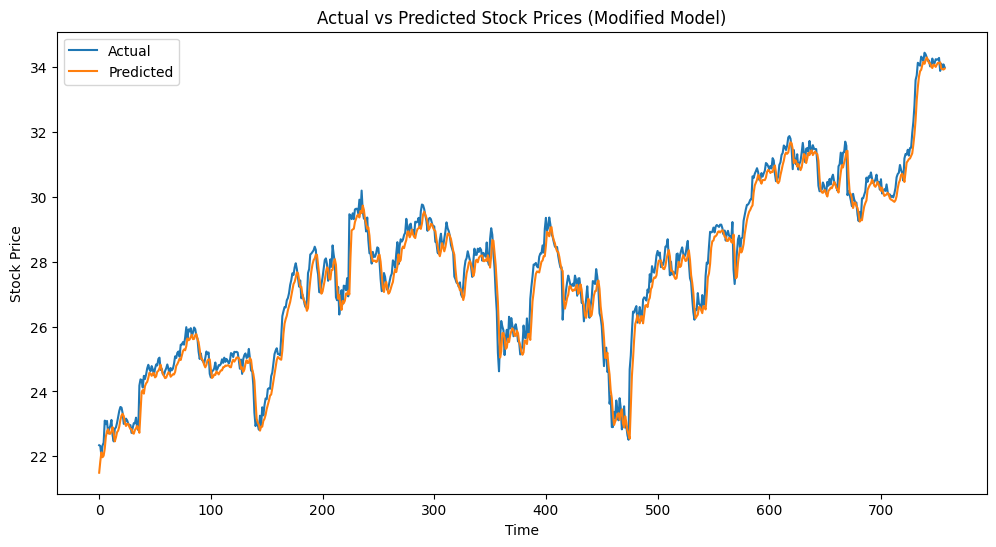

Modified Model:
RMSE: 0.431788889309787
MAE: 0.32824273222669126
MAPE: 0.011984345069640806


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
modified_predictions = modifikasi3_model.predict(test_windows2)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels2, modified_predictions))
modified_mae = mean_absolute_error(test_labels2, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels2, modified_predictions)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Modified Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)


Hasil dari modifikasi ke-3 lebih besar daripada sebelumnya yaitu sebesar
- RMSE 4,3%
- MAE 3,2%
- MAPE 0,1%

kemudian untuk plot sudah sangat bagus dan hampir menyerupai aslinya, memang secara garis sempit nilai prediksti dan nilai sebenarnya tidaklah dapat dikatakan identik. namun pada hasil RMSE, MAE, ataupun MAPE sudah dapat dikatakan bagus.

## Modifikasi 4

In [ ]:
from tensorflow.keras.optimizers import Adam

def modif_model():
    model = Sequential()
    model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
    model.add(LSTM(units=64, activation='relu', return_sequences=True))
    model.add(LSTM(units=32, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))
    return model

# Create the modified model
modifikasi4_model = modif_model()

# Define the learning rate
learning_rate = 0.001

# Compile the model with Adam optimizer and specified learning rate
modifikasi4_model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

# Print the model summary
modifikasi4_model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 5, 128)            66560     
                                                                 
 lstm_26 (LSTM)              (None, 5, 64)             49408     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 130,561
Trainable params: 130,561
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = modifikasi4_model.fit(train_windows2, train_labels2,
                             validation_data=(val_windows2, val_labels2),
                             epochs=12, batch_size=32)

# Evaluate the model on the test set
test_loss = modifikasi4_model.evaluate(test_windows2, test_labels2)
print("Test Loss:", test_loss)

Epoch 1/12
190/190 [==============================] - 21s 53ms/step - loss: 21.7885 - val_loss: 7.2135
Epoch 2/12
190/190 [==============================] - 6s 31ms/step - loss: 1.3930 - val_loss: 1.4570
Epoch 3/12
190/190 [==============================] - 6s 31ms/step - loss: 1.1355 - val_loss: 12.6424
Epoch 4/12
190/190 [==============================] - 4s 21ms/step - loss: 1.2028 - val_loss: 1.1237
Epoch 5/12
190/190 [==============================] - 4s 22ms/step - loss: 1.2274 - val_loss: 2.1643
Epoch 6/12
190/190 [==============================] - 8s 40ms/step - loss: 1.2023 - val_loss: 1.1755
Epoch 7/12
190/190 [==============================] - 9s 46ms/step - loss: 0.9272 - val_loss: 1.0389
Epoch 8/12
190/190 [==============================] - 8s 42ms/step - loss: 0.9940 - val_loss: 3.3794
Epoch 9/12
190/190 [==============================] - 4s 22ms/step - loss: 0.8795 - val_loss: 1.0575
Epoch 10/12
190/190 [==============================] - 5s 27ms/step - loss: 0.7331 - val

24/24 [==============================] - 2s 18ms/step


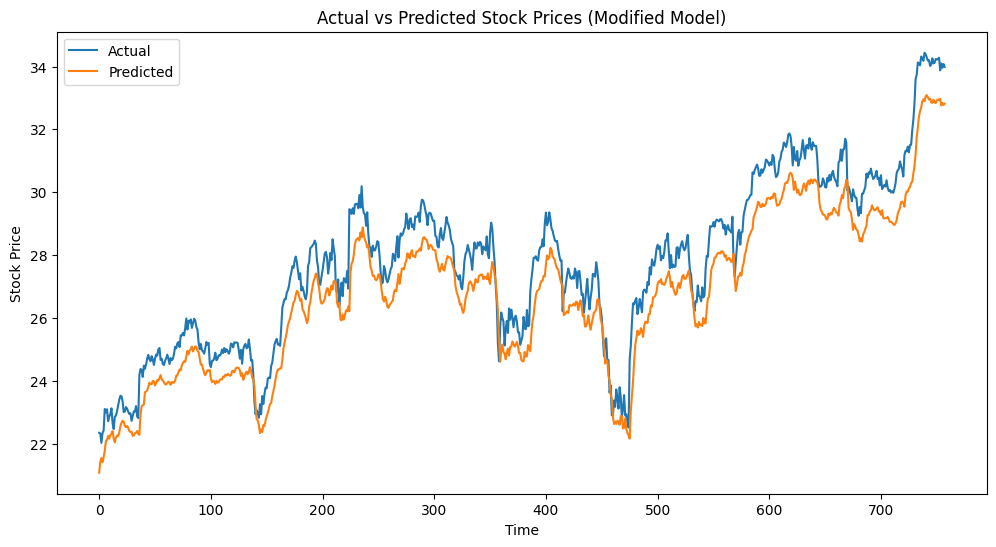

Modified Model:
RMSE: 1.0535059309301031
MAE: 0.9766999121391678
MAPE: 0.034896837567027716


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
modified_predictions = modifikasi4_model.predict(test_windows2)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels2, modified_predictions))
modified_mae = mean_absolute_error(test_labels2, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels2, modified_predictions)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Modified Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)


### d. [LO 3, LO 4, 5 poin] Lakukan evaluasi unjuk kerja kedua arsitektur di atas pada test set dengan mencari nilai RMSE, MAE dan MAPE. Dan berikan penjelasan mengenai hasilnya dengan rinci

# Dataset AMZN

### Evaluasi Baseline AMZN

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get predictions from the baseline model
baseline_predictions = baseline_model.predict(test_windows)

# Flatten the predictions and test labels to 1D arrays
baseline_predictions = baseline_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
baseline_rmse = np.sqrt(mean_squared_error(test_labels, baseline_predictions))
baseline_mae = mean_absolute_error(test_labels, baseline_predictions)
baseline_mape = mean_absolute_percentage_error(test_labels, baseline_predictions)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE: ", baseline_mape)


18/18 [==============================] - 0s 2ms/step
Baseline Model:
RMSE: 0.026350532062919662
MAE: 0.022857587625219077
MAPE:  0.05860113397286456


modifikasi arsitektur saham Amazon mendapatkan hasil yang lebih baik daripada baseline pada modifikasi ke-2.  Pada modifikasi ke-2 saham Amazon, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU Karena argumen return_sequences diatur sebagai default False.
- kemudian saya juga menambahkan Dropout layer untuk regularization.
- terdapat dense layer ditambahkan ke model. Dense merupakan layer biasa dnegan satu unit tanpa fungsi activasi. berhasil mengalahkan arsitektur baseline dengan arsitektur dibawah ini.

Function baselineModel digunakan untuk menghasilkan model baseline yang digunakan untuk memprediksi dari pergerakan harga saham. Dengan menggunakan LSTM sebesar 50 units dan layer akhir berupa node perceptron dengan units 1, Activation function untuk LSTM menggunakan ReLU.

Output diatas menunjukkan bahwa jumlah parameter pada layer tersebut adalah 10.451.
Arsitektur model :
- Model tersebut menggunakan LSTM 50 units, activation function relu, dan layer akhir berupa
node Perceptron dengan units=1.
- Model tersebut mengkompilasi model baseline yang telah dibuat sebelumnya. Dengan menggunakan 'loss=mse' parameter ini mengatur fungsi loss dalam training. Mean Square Error atau biasa disingkat MSE merupakan metrik umum yang digunakan untuk mengukur nilai prediksi dan nilai aktual.
- optimizer='adam' untuk memperbarui parameter model selama training [5].




Referensi :
[5]  Buchwalder, M., Bühlmann, H., Merz, M., & Wüthrich, M. V. (2006). The mean square error of prediction in the chain ladder reserving method (Mack and Murphy revisited). ASTIN Bulletin: The Journal of the IAA, 36(2), 521-542.





### Modifikasi 2 AMZN

In [ ]:
# Predict on the test set
modified_predictions = modifikasi2_model.predict(test_windows)

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels, modified_predictions))
modified_mae = mean_absolute_error(test_labels, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels, modified_predictions)

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)

18/18 [==============================] - 0s 4ms/step
Modified Model:
RMSE: 0.009835162782032522
MAE: 0.007036769384357762
MAPE: 0.02017197741943435


modifikasi arsitektur saham Amazon mendapatkan hasil yang lebih baik daripada baseline pada modifikasi ke-2. Pada modifikasi ke-2 saham Amazon, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU Karena argumen return_sequences diatur sebagai default False.
- kemudian saya juga menambahkan Dropout layer untuk regularization.
- terdapat dense layer ditambahkan ke model. Dense merupakan layer biasa dnegan satu unit tanpa fungsi activasi. berhasil mengalahkan arsitektur baseline dengan arsitektur dibawah ini.

mendapatkan Hasil dari modifikasi ke-2 lebih rendah daripada sebelumnya yaitu sebesar
- RMSE 0.09%
- MAE 0.07%
- MAPE 0,2%

kemudian untuk plot sudah sangat bagus dan hampir menyerupai aslinya, memang secara garis sempit nilai prediksti dan nilai sebenarnya tidaklah dapat dikatakan identik. namun pada hasil RMSE, MAE, ataupun MAPE sudah dapat dikatakan bagus.

# Dataset CSCO

### Evaluasi Baseline CSCO

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Get predictions from the baseline model
baseline_predictions = baseline_model.predict(test_windows2)

# Flatten the predictions and test labels to 1D arrays
baseline_predictions = baseline_predictions.flatten()
test_labels = test_labels2.flatten()

# Calculate evaluation metrics
baseline_rmse = np.sqrt(mean_squared_error(test_labels2, baseline_predictions))
baseline_mae = mean_absolute_error(test_labels2, baseline_predictions)
baseline_mape = mean_absolute_percentage_error(test_labels2, baseline_predictions)

print("Baseline Model:")
print("RMSE:", baseline_rmse)
print("MAE:", baseline_mae)
print("MAPE: ", baseline_mape)


24/24 [==============================] - 0s 2ms/step
Baseline Model:
RMSE: 0.4671533895912917
MAE: 0.37193820470241257
MAPE:  0.013441341685941735


Function baselineModel digunakan untuk menghasilkan model baseline yang digunakan untuk memprediksi dari pergerakan harga saham. Dengan menggunakan LSTM sebesar 50 units dan layer akhir berupa node perceptron dengan units 1, Activation function untuk LSTM menggunakan ReLU.

Output diatas menunjukkan bahwa jumlah parameter pada layer tersebut adalah 10.451.
Arsitektur model :
- Model tersebut menggunakan LSTM 50 units, activation function relu, dan layer akhir berupa
node Perceptron dengan units=1.
- Model tersebut mengkompilasi model baseline yang telah dibuat sebelumnya. Dengan menggunakan 'loss=mse' parameter ini mengatur fungsi loss dalam training. Mean Square Error atau biasa disingkat MSE merupakan metrik umum yang digunakan untuk mengukur nilai prediksi dan nilai aktual.
- optimizer='adam' untuk memperbarui parameter model selama training [5].

Referensi :
[5]  Buchwalder, M., Bühlmann, H., Merz, M., & Wüthrich, M. V. (2006). The mean square error of prediction in the chain ladder reserving method (Mack and Murphy revisited). ASTIN Bulletin: The Journal of the IAA, 36(2), 521-542.



Didapat baseline model dari Arsitekur LSTM Cisco dengan unit = 50 dan layer akhir node perceptron dengan unit = 1, serta Activation function.

Dapat dilihat nilai RMSE, MAE, MAPE sudah cukup terbilang bagus. dan plot sudah terlihat normal, meski plot tidak terlalu menyatu.

Hasil baseline dari arsitektur LSTM mendapatkan hasil :        

- RMSE: 4,6%
- MAE: 3,7%
- MAPE:  0,1%

hasil yang didapat sudah memiliki hasil yang cukup rendah, itu artinya sudah baik. Jika nilai RMSE, MAE, dan MAPE semakin rendah itu artinya model sudah bagus.

### Modifikasi paling bagus

24/24 [==============================] - 1s 13ms/step


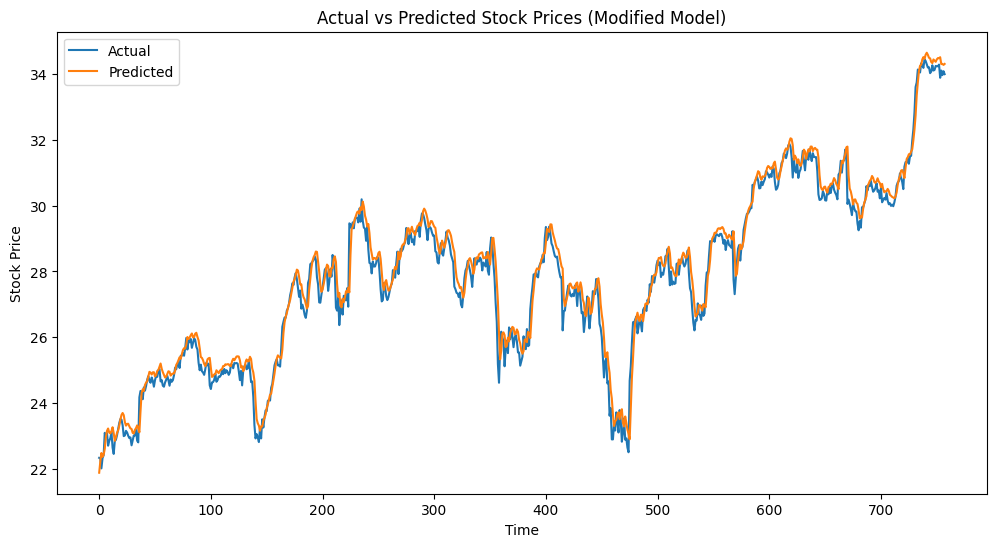

Modified Model:
RMSE: 0.4284477930001174
MAE: 0.3159616087860671
MAPE: 0.01162260270723021


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
modified_predictions = modifikasi2_model.predict(test_windows2)

# Flatten the predictions and test labels to 1D arrays
modified_predictions = modified_predictions.flatten()
test_labels = test_labels.flatten()

# Calculate evaluation metrics
modified_rmse = np.sqrt(mean_squared_error(test_labels2, modified_predictions))
modified_mae = mean_absolute_error(test_labels2, modified_predictions)
modified_mape = mean_absolute_percentage_error(test_labels2, modified_predictions)

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='Actual')
plt.plot(modified_predictions, label='Predicted')
plt.title('Actual vs Predicted Stock Prices (Modified Model)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

print("Modified Model:")
print("RMSE:", modified_rmse)
print("MAE:", modified_mae)
print("MAPE:", modified_mape)


modifikasi arsitektur saham Cisco mendapatkan hasil yang lebih baik daripada baseline pada modifikasi ke-2. yaitu mendapatkan hasil Hasil dari modifikasi ke-2 lebih rendah daripada sebelumnya yaitu sebesar
- RMSE 0.09%
- MAE 0.07%
- MAPE 0,2%

kemudian untuk plot sudah sangat bagus dan hampir menyerupai aslinya, memang secara garis sempit nilai prediksti dan nilai sebenarnya tidaklah dapat dikatakan identik. namun pada hasil RMSE, MAE, ataupun MAPE sudah dapat dikatakan bagus.  Pada modifikasi ke-2 saham Amazon, saya menambahkan beberapa layer, yaitu :                
- pada layer kedua menambahkan layer LSTm dengan 64 unit kemudian menggunakan fungsi activation ReLU Karena argumen return_sequences diatur sebagai default False.
- kemudian saya juga menambahkan Dropout layer untuk regularization.
- terdapat dense layer ditambahkan ke model. Dense merupakan layer biasa dnegan satu unit tanpa fungsi activasi. berhasil mengalahkan arsitektur baseline dengan arsitektur dibawah ini.

Function baselineModel digunakan untuk menghasilkan model baseline yang digunakan untuk memprediksi dari pergerakan harga saham. Dengan menggunakan LSTM sebesar 50 units dan layer akhir berupa node perceptron dengan units 1, Activation function untuk LSTM menggunakan ReLU.

Output diatas menunjukkan bahwa jumlah parameter pada layer tersebut adalah 10.451.
Arsitektur model :
- Model tersebut menggunakan LSTM 50 units, activation function relu, dan layer akhir berupa
node Perceptron dengan units=1.
- Model tersebut mengkompilasi model baseline yang telah dibuat sebelumnya. Dengan menggunakan 'loss=mse' parameter ini mengatur fungsi loss dalam training. Mean Square Error atau biasa disingkat MSE merupakan metrik umum yang digunakan untuk mengukur nilai prediksi dan nilai aktual.
- optimizer='adam' untuk memperbarui parameter model selama training [5].

Referensi :
[5]  Buchwalder, M., Bühlmann, H., Merz, M., & Wüthrich, M. V. (2006). The mean square error of prediction in the chain ladder reserving method (Mack and Murphy revisited). ASTIN Bulletin: The Journal of the IAA, 36(2), 521-542.

https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16





### Kesmpulan
didapat hasil yang bagus pada arsitektur model ke-2, pada saham Amazon maupun Cisco.  hal ini dikarenakan tidak banyak menambahkan layer dan tidak memakai dropout layer. karena dalam beberapa kasus dropout layert tidak dipakai dan tetap mendapatkan performa yang baik, serta dengan tidak memakai dropout layer mempercepat proses pelatihan data.

selain itu ada argumen lain mengenai dropout bahwa dropout dipakai akan membuat data menjaadi bias sehingga, mempengaruhi evaluasi terhadap model.
Bell, M. L., Kenward, M. G., Fairclough, D. L., & Horton, N. J. (2013). Differential dropout and bias in randomised controlled trials: when it matters and when it may not. Bmj, 346.

kemudian dengan menambahkan LSTM dalam layer model akan lebih memahami sehingga membuat prediksi yang lebih baik.
Kurata, G., Ramabhadran, B., Saon, G., & Sethy, A. (2017, December). Language modeling with highway LSTM. In 2017 IEEE Automatic Speech Recognition and Understanding Workshop (ASRU) (pp. 244-251). IEEE.

E. Link Video : https://youtu.be/hWP981sy2Fw